# Fix policy in Q-Learning & Policy Iteration

This script is used to compare the tabular Q-Learning and policy iteration with the optimal policy from dual LP.

**Logs**:
+ 2023-07-25 Results from q-learning does not converge away from the optimal. We tried the PI, which converges and gives better results.

In [2]:
# a temporary solution, run twice to set the current path as '../Fair-RL/src'
%cd ..

/Users/xiaohui/SpyderProjects/PhD/Fair-RL/src


In [4]:
import argparse

from env.mrp_env import MachineReplace
from experiments.configs.config_shared import prs_parser_setup
import seaborn as sns
import numpy as np


# configuration parameters
prs = argparse.ArgumentParser(
    formatter_class=argparse.ArgumentDefaultsHelpFormatter,
    description="""Tabular Q Learning.""",
)
prs = prs_parser_setup(prs)
args, _ = prs.parse_known_args()

# check parameters
args

Namespace(ggi=False, n_action=2, n_group=3, n_state=3, weight=2)

## Q-learning

In [24]:
class QAgent:
    def __init__(self, env, num_states, num_actions, alpha, epsilon, gamma):
        self.env = env
        self.num_states = num_states
        self.num_actions = num_actions
        self.q_table = np.random.uniform(
            low=0, high=0.01, size=(num_states, num_actions)
        )
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def get_action(self, state):
        # We use epsilon-greedy to get an action
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(self.q_table[state][:])
        return action

    def update_q_function(self, state, action, reward, state_next):
        # Update the Q function with linear function approximation
        # In this case, equivalent to the tabular Q-Learning
        q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + self.alpha * (
            reward + self.gamma * q_next - self.q_table[state, action]
        )

    def get_policy(self):
        # We use greedy to decide an optimal policy
        state_action_pair = {}
        for state in range(self.num_states):
            state_action_pair[state] = np.argmax(self.q_table[state][:])
        return state_action_pair


def run_tabular_q(
    env, num_episodes=200, len_episode=1000, alpha=0.1, epsilon=0.2, gamma=0.99
):
    episode_rewards = []
    agent = QAgent(
        env=env,
        num_states=env.observation_space.n,
        num_actions=env.action_space.n,
        alpha=alpha,
        epsilon=epsilon,
        gamma=gamma,
    )
    # Run 1000 episodes
    for episode in range(num_episodes):
        # Initialize environment
        state = env.reset()
        total_reward = 0
        for t in range(len_episode):
            # Get an action
            action = agent.get_action(state)
            # Move
            state_next, reward, done, _ = env.step(action)
            # Update Q table
            agent.update_q_function(state, action, reward, state_next)
            # Update observation
            state = state_next
            total_reward += (gamma ** t) * reward
        # Display running rewards
        if episode % 20 == 0:
            print(f"Episode: {episode}; " f"Running reward: {total_reward:.1f}.")
        episode_rewards.append(total_reward)
    state_action_pair = agent.get_policy()
    return state_action_pair, episode_rewards

In [16]:
# initialize the MRP environment
env = MachineReplace(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    init_state=0,
    ggi=args.ggi,
)

tabular_q_policy, episode_rewards = run_tabular_q(
    env=env, num_episodes=200, len_episode=1500, alpha=0.05, epsilon=0.2, gamma=0.90
)

Episode: 0; Running reward: 1740.7.
Episode: 20; Running reward: 1669.3.
Episode: 40; Running reward: 1699.8.
Episode: 60; Running reward: 1853.2.
Episode: 80; Running reward: 1837.3.
Episode: 100; Running reward: 1923.0.
Episode: 120; Running reward: 1881.8.
Episode: 140; Running reward: 1926.7.
Episode: 160; Running reward: 1926.1.
Episode: 180; Running reward: 1913.5.


<AxesSubplot:>

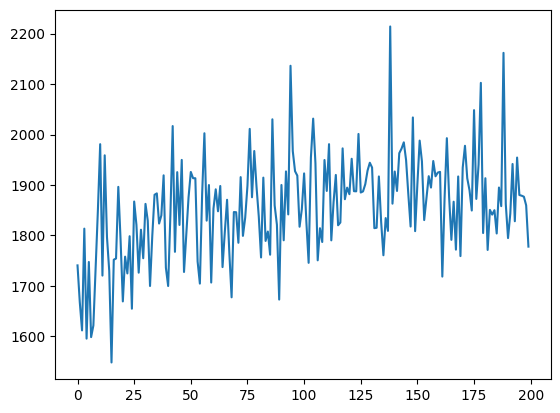

In [17]:
sns.lineplot(episode_rewards)

Next, we fix the policy from q-learning and solve.

In [18]:
import numpy as np

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

# Build data
from utils.mrp_lp import MRPData

weight_coef = np.array([1 / (2 ** i) for i in range(args.n_group)])
data_mrp = MRPData(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    weight=weight_coef,
)  # TODO: not by default

model = build_ggf_fix(data_mrp, tabular_q_policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=data_mrp, policy_rl=tabular_q_policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0x034d72f4
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 128 rows and 101 columns
Presolve time: 0.01s
Presolved: 16 rows, 13 columns, 102 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.135632e+02   0.000000e+00      0s
      14    3.8486426e+02   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.848642613e+02
x((0, 0, 0), 1): 0.39708094596922544
x((0, 0, 1), 0): 0.3051970260198111
x((0, 0, 2), 3): 0.285969558303222
x((0, 1, 0), 2): 0.3748066749633743
x((0, 1, 1), 0

[980.0, 870.0, 970.0]

## Dual LP
Optimal solutions from dual LP is given as:

In [21]:
import numpy as np

# Build data
from utils.mrp_lp import MRPData

weight_coef = np.array([1 / (2 ** i) for i in range(args.n_group)])
data_mrp = MRPData(
    n_group=args.n_group,
    n_state=args.n_state,
    n_action=args.n_action,
    weight=weight_coef,
)  # TODO: not by default

# results for ggf dual
from solver.ggf_dual import build_ggf, extract_results, solve_ggf

# Build t1he GGF model
ggf_model_lp = build_ggf(data=data_mrp)
# Solve the GGF model
results_lp, ggf_model_lp = solve_ggf(model=ggf_model_lp)
# Extract the results
extract_results(model=ggf_model_lp, data=data_mrp)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 36 rows, 114 columns and 1592 nonzeros
Model fingerprint: 0xcfb725c3
Coefficient statistics:
  Matrix range     [1e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve time: 0.00s
Presolved: 36 rows, 114 columns, 1592 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.259259e+00   0.000000e+00      0s
      60    4.1508739e+01   0.000000e+00   0.000000e+00      0s

Solved in 60 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.150873891e+01
x((0, 0, 0), 0): 0.08962194783040893
x((0, 0, 1), 0): 0.065000707827664
x((0, 0, 2), 0): 0.04778972520908004
x((0, 1, 0), 0): 0.065000707827664
x((0, 1, 1), 0): 0.04702182841440925
x((0, 1, 2), 3): 0

[41.50873891260395, 41.508738912603974, 41.508738912603974]

## Policy Iteration

In [23]:
"""This script is used to run policy iteration algorithm."""

import numpy as np

from utils.mrp_lp import MRPData


class PIAgent:
    def __init__(self, params, gamma=0.99, theta=1e-10):
        self.mrp_data = MRPData(
            n_group=params["n_group"],
            n_state=params["n_state"],
            n_action=params["n_action"],
            weight=None
        )
        self.ggi = params["ggi"]
        self.gamma = gamma  # discount factor
        self.theta = theta  # threshold to stop policy evaluation
        self.n_state = len(self.mrp_data.idx_list_s)
        self.n_action = len(self.mrp_data.idx_list_a)

    def policy_evaluation(self, pi):
        prev_V = np.zeros(self.n_state, dtype=np.float64)
        while True:
            V = np.zeros(self.n_state, dtype=np.float64)
            for s in range(self.n_state):
                next_state_prob = self.mrp_data.bigT[s, :, pi(s)]
                reward = sum(-self.mrp_data.bigC[s, pi(s), :] + 110)
                V[s] += reward + self.gamma * np.dot(prev_V, next_state_prob)
            if np.max(np.abs(prev_V - V)) < self.theta:
                break
            prev_V = V.copy()
        return V

    def policy_improvement(self, V):
        Q = np.zeros((self.n_state, self.n_action), dtype=np.float64)
        for s in range(self.n_state):
            for a in range(self.n_action):
                next_state_prob = self.mrp_data.bigT[s, :, a]
                reward = sum(-self.mrp_data.bigC[s, a, :] + 110)
                Q[s][a] += reward + self.gamma * np.dot(V, next_state_prob)
        new_pi = lambda s: {s: a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
        return new_pi

    def run_policy_iteration(self):
        init_actions = [0 for s in range(self.n_state)]
        pi = lambda s: {s: 0 for s, a in enumerate(init_actions)}[s]
        while True:
            old_pi = {s: pi(s) for s in range(self.n_state)}
            if not self.ggi:
                Vs = self.policy_evaluation(pi)
                pi = self.policy_improvement(Vs)
            else:
                # TODO: add GGF policy evaluation and improvement
                Vs = self.policy_evaluation(pi)
                pi = self.policy_improvement(Vs)
            # convergence check
            if old_pi == {s: pi(s) for s in range(self.n_state)}:
                break
        return Vs, pi


# initialize the environment
params = {"n_group": 3, "n_state": 3, "n_action": 2, "ggi": False}
# initialize the agent
policy_agent = PIAgent(params, gamma=0.99, theta=1e-10)
# run policy iteration
V, pi = policy_agent.run_policy_iteration()
policy = {s: pi(s) for s in range(policy_agent.n_state)}

# results for fixing the RL policy
from solver.fix_policy import (
    build_ggf_fix,
    extract_results as extract_results_fix,
    solve_ggf_fix,
)

model = build_ggf_fix(policy_agent.mrp_data, policy)
# Solve the GGF model
results, ggf_model = solve_ggf_fix(model=model)
extract_results_fix(model=ggf_model, data=policy_agent.mrp_data, policy_rl=policy)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 114 columns and 1754 nonzeros
Model fingerprint: 0x3cdd362e
Coefficient statistics:
  Matrix range     [1e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 4e-02]
Presolve removed 135 rows and 108 columns
Presolve time: 0.01s
Presolved: 9 rows, 6 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.281388e+02   0.000000e+00      0s
       5    4.2712922e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.271292196e+01
x((0, 0, 0), 0): 0.08731825744639655
x((0, 0, 1), 0): 0.058942855336372155
x((0, 0, 2), 3): 0.037037037037037035
x((0, 1, 0), 0): 0.058942855336372155
x((0, 1, 1)

[1260.0, 1080.0, 960.0]